In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

series = pd.read_csv("../dados/series_log.csv")

## Tratamento das séries

In [6]:
# tratamento das séries
# extraindo os resíduos da reg. pib_mensal ~ 1 + trend
series["pib_mensal"] = sm.OLS(
    series.pib_mensal, pd.DataFrame({"const": 1, "trend": range(1, len(series) + 1)})
).fit().resid

# primeira diferença das variáveis não-estacionárias
for col in ["spread", "selic", "inad", "igp", "ihh"]:
    series[col] = series.loc[:, col].diff()


## Pré-estimação: seleção das variáveis endógenas e exógenas

In [7]:
# selecionando as variáveis endógenas e exógenas
endog_vars = ["spread", "selic", "ihh", "inad"]
exog_vars = ["igp", "pib_mensal"]

# se usando ihh
series["date"] = pd.to_datetime(series.date)
if "ihh" in endog_vars:
    series = series.query('date.dt.year <= 2017')
    
# ignorar na
series = series.loc[:, endog_vars + exog_vars].dropna()

In [8]:
# estimando o VAR
model = VAR(endog=series.loc[:, endog_vars], exog=series.loc[:, exog_vars])

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Estimação e seleção do número de defasagens

In [9]:
print(model.select_order(12))
print(model.select_order(12).summary())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 12, BIC -> 1, FPE -> 7, HQIC -> 6>
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -30.59      -30.20   5.196e-14      -30.43
1       -31.22     -30.32*   2.762e-14      -30.86
2       -31.28      -29.86   2.628e-14      -30.72
3       -31.64      -29.70   1.862e-14      -30.87
4       -31.59      -29.13   2.024e-14      -30.61
5       -31.52      -28.54   2.270e-14      -30.34
6       -32.27      -28.77   1.153e-14     -30.88*
7       -32.47      -28.45  1.047e-14*      -30.87
8       -32.24      -27.71   1.510e-14      -30.44
9       -32.24      -27.19   1.826e-14      -30.23
10      -32.56      -26.99   1.703e-14      -30.35
11      -32.88      -26.80   1.741e-14      -30.47
12     -33.11*      -26.51   2.225e-14      -30.49
--------------------------------------------------


In [23]:
number_of_lags = 1
results = model.fit(number_of_lags)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 27, Oct, 2019
Time:                     15:28:40
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -30.5866
Nobs:                     80.0000    HQIC:                  -31.0860
Log likelihood:           830.750    FPE:                2.26532e-14
AIC:                     -31.4203    Det(Omega_mle):     1.61962e-14
--------------------------------------------------------------------
Results for equation spread
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.005994         0.003930            1.525           0.127
exog0             0.000342         0.000468            0.730           0.465
exog1            -0.328652         0.101410           -3.241           0.00

## Gráfico das séries

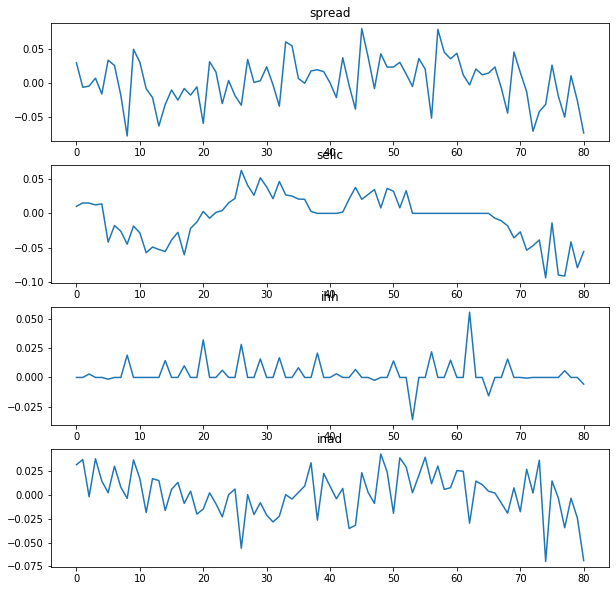

In [19]:
results.plot();

## Teste de autocorrelação residual

In [12]:
print(results.test_whiteness(nlags=number_of_lags + 1).summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 2 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         25.59          26.30   0.060 16
----------------------------------------


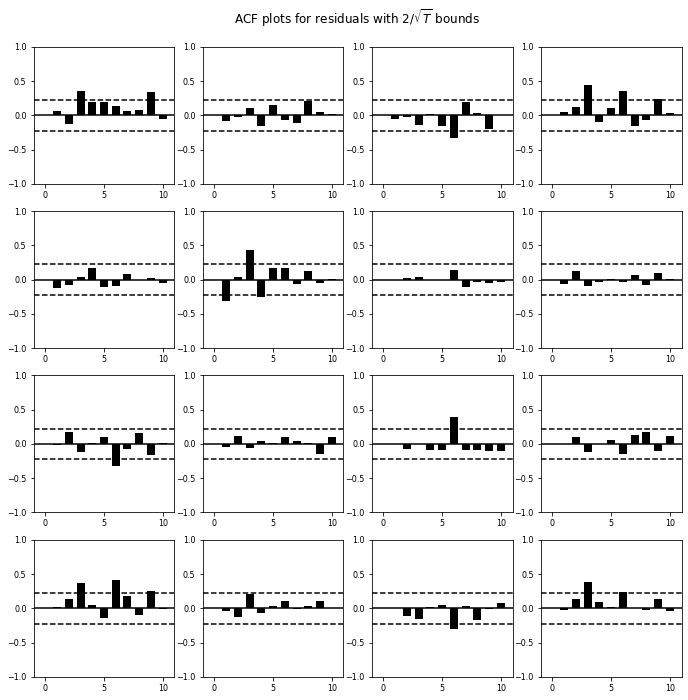

In [20]:
results.plot_acorr();

## Função de impulso resposta

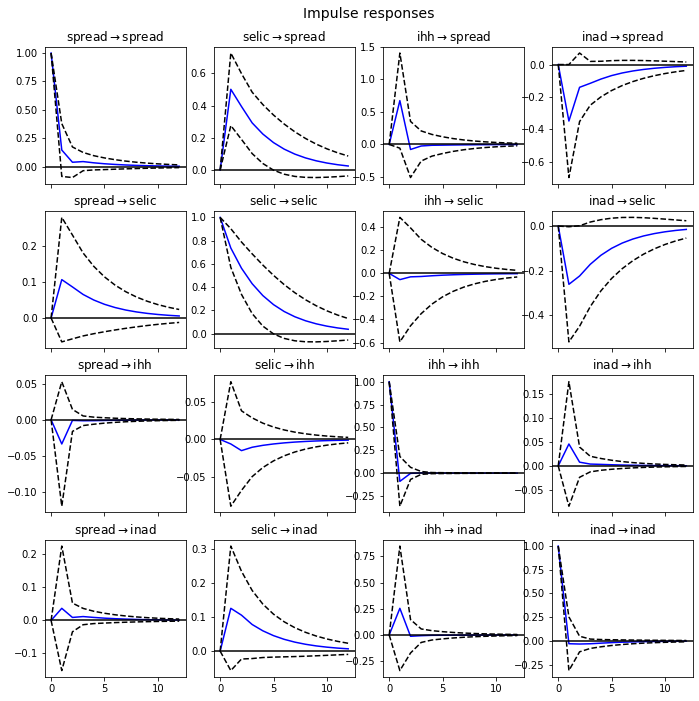

In [21]:
results.irf(12).plot();